In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import torch


In [3]:
words = open('names.txt', 'r').read().splitlines()

for word in words[:10]:
  print(word)

emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn


In [4]:
chars = sorted(list(set("".join(words))))
stoi = {}
stoi["."] = 0
stoi.update({s: i + 1 for i, s in enumerate(chars)})
itos = {i: s for s, i in stoi.items()}

itos_complex = {}
for i in range(27):
    for j in range(27):
        itos_complex[i * 27 + j] = f"{itos[i]}{itos[j]}"

def my_plot(matrix, x_itos, y_itos, max_rows=None):
    if max_rows is not None:
        matrix = matrix[:max_rows]
        x_itos = {k: v for k, v in x_itos.items() if k < max_rows}
    
    plt.figure(figsize=(16, 16))
    plt.imshow(matrix, cmap='Blues')
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            chstr = x_itos[i] + y_itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
            plt.text(j, i, matrix[i, j].item(), ha="center", va="top", color='gray')
    
    plt.axis('off')
    plt.show()

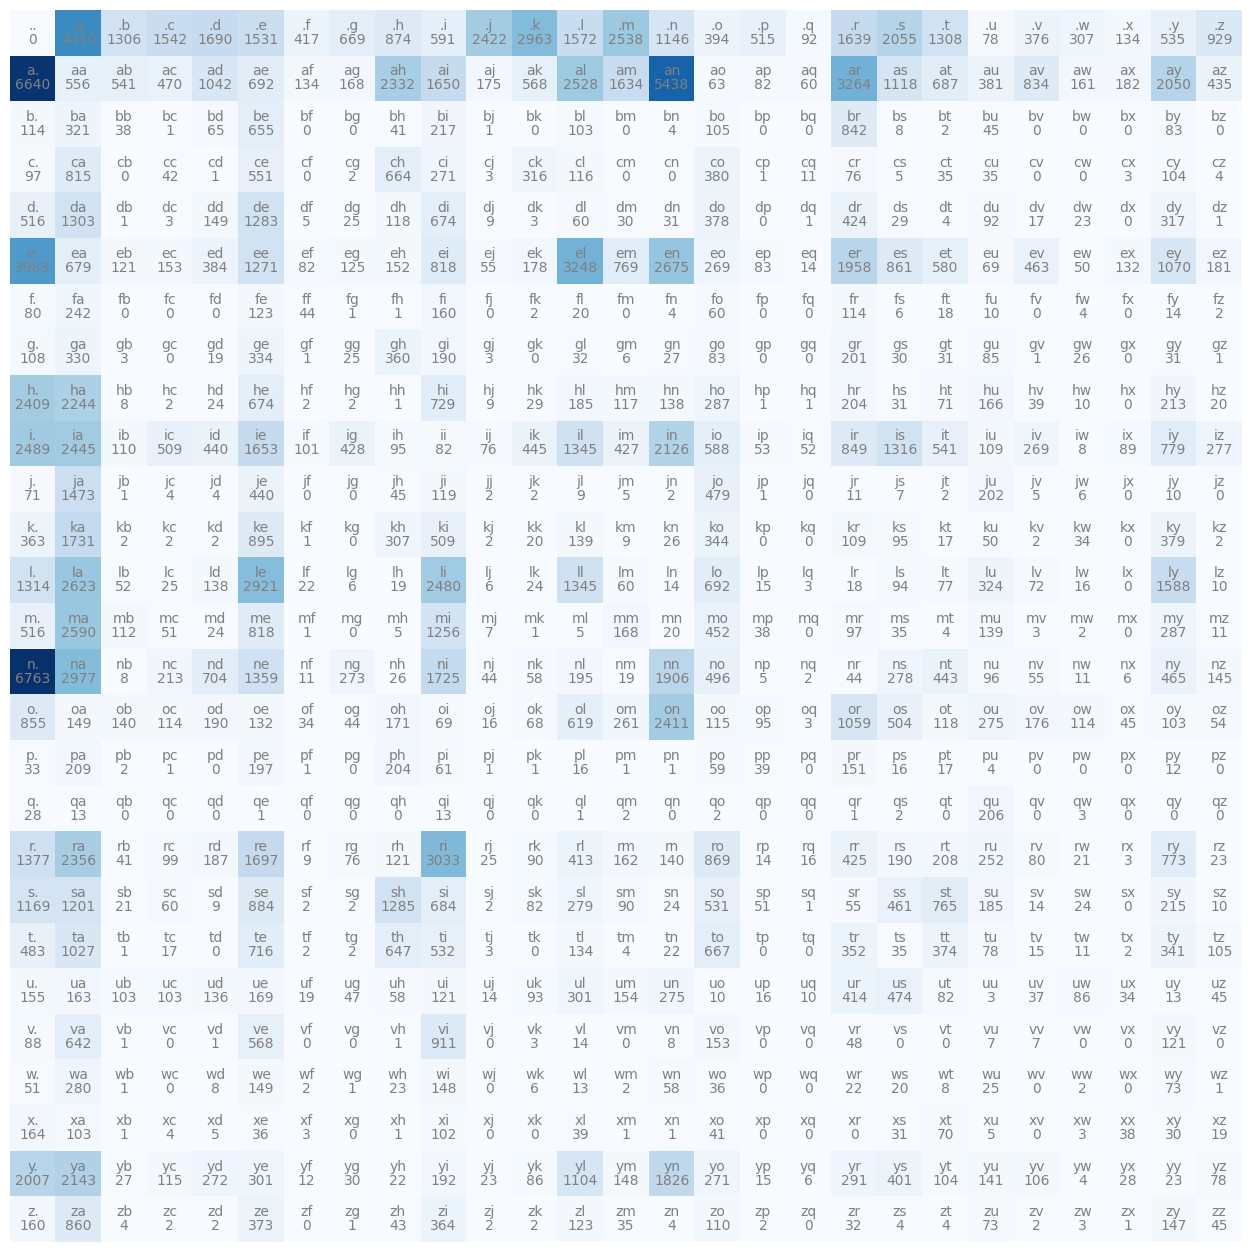

In [5]:
N = torch.zeros((27, 27), dtype=torch.int32)
for word in words:
    chs = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        row = stoi[ch1]
        col = stoi[ch2]
        N[row, col] += 1

P = N.float() + 1.0  # with model smoothing
P /= P.sum(dim=1, keepdim=True)

my_plot(N, itos, itos)

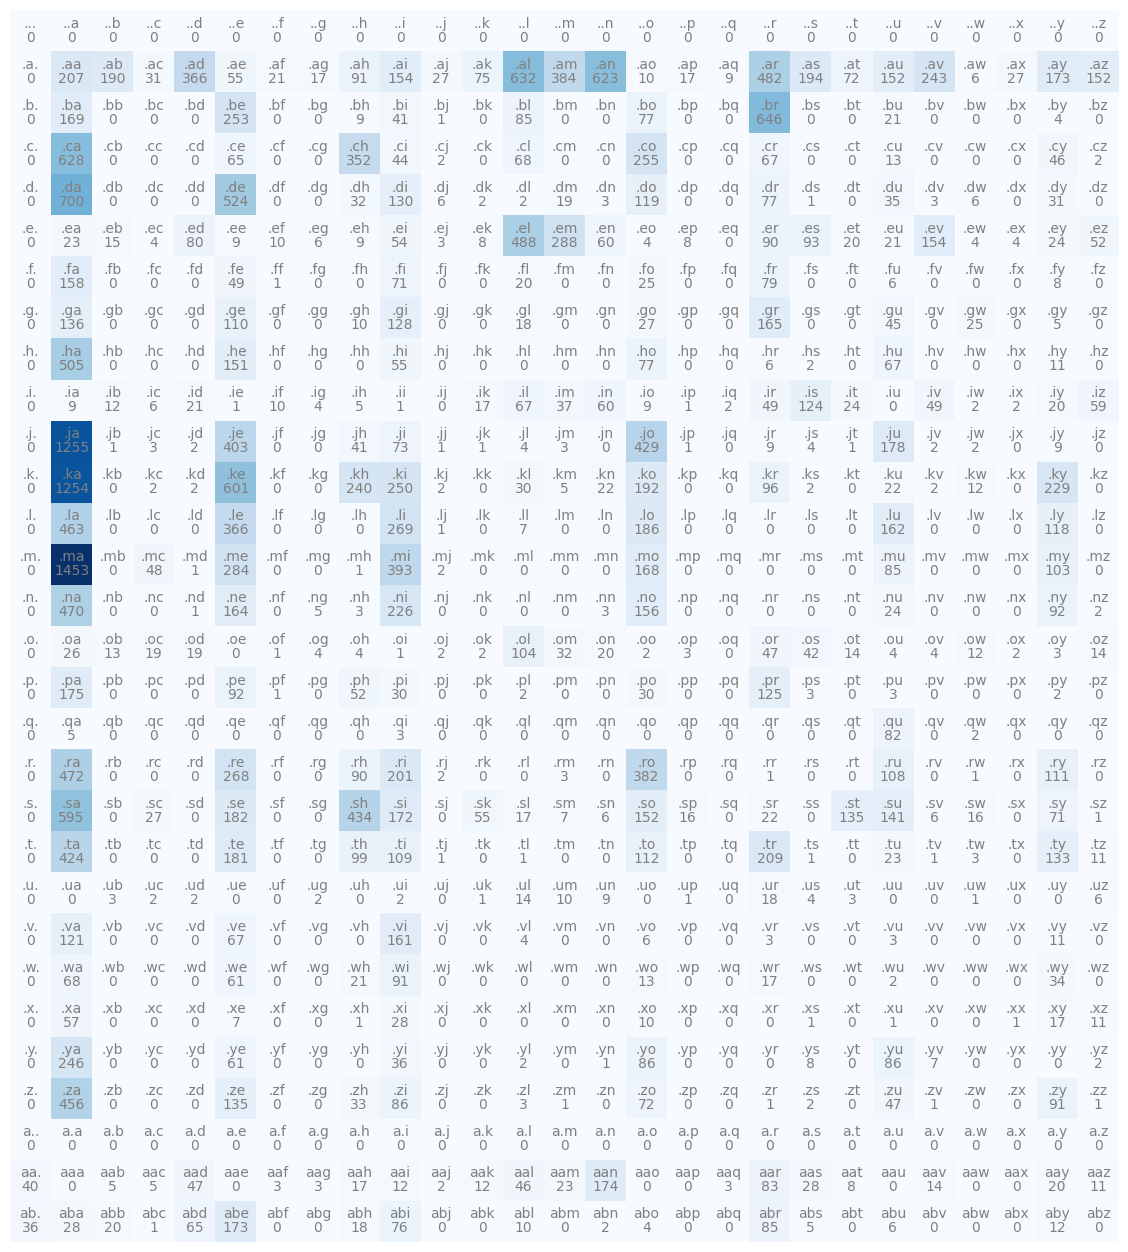

In [6]:
N_complex = torch.zeros((27 * 27, 27), dtype=torch.int32)
for word in words:
    chs = ["."] + list(word) + ["."]
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1] * 27 + stoi[ch2]
        ix2 = stoi[ch3]
        N_complex[ix1, ix2] += 1

P_complex = N_complex.float() + 1.0  # with model smoothing
P_complex /= P_complex.sum(dim=1, keepdim=True)

my_plot(N_complex[:30], dict(list(itos_complex.items())[:30]), itos)

In [7]:
# Sampling from table model
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    context = [0]
    out = []
    while True:

        # Get current context
        ch1 = context[-1]
        context_ix = ch1

        # Probability approach
        ix = torch.multinomial(P[context_ix], num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

        # Update context
        context = [ix]

    print("".join(out))

# Probabilistic loss
log_likelihood = 0.0
n=0
for word in words:
  chs = ['.'] + list(word) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prop = P[ix1,ix2]
    logprop = torch.log(prop)
    log_likelihood += logprop
    n+=1
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n=}")

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
nll/n=tensor(2.4544)


In [8]:
# Sampling from table model
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    context = [0, 0]
    out = []
    while True:
        
        # Get current context
        ch1, ch2 = context[-2], context[-1]
        context_ix = ch1 * 27 + ch2

        # Probability approach
        ix = torch.multinomial(P_complex[context_ix], num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

        # Update context
        context = [ch2, ix]

    print("".join(out))

# Probabilistic loss
log_likelihood = 0.0
n=0
for word in words:
  chs = ['.'] + list(word) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1] * 27 + stoi[ch2]
    ix2 = stoi[ch3]
    prop = P_complex[ix1,ix2]
    logprop = torch.log(prop)
    log_likelihood += logprop
    n+=1
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n=}")

ce.
za.
zogh.
uriana.
kaydnevonimittain.
log_likelihood=tensor(-410414.9688)
nll=tensor(410414.9688)
nll/n=tensor(2.0927)


In [9]:
xs, ys = [], []

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1] * 27 + stoi[ch2]
    ix2 = stoi[ch3]
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27*27).float()

In [10]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*27, 27), generator=g, requires_grad=True)

for k in range(50):

    # forward pass
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(len(xs)), ys].log().mean() + 0.01 * (W**2).mean()

    # backward pass
    W.grad = None
    loss.backward()

    # update	
    if k > 40:
        W.data -= W.grad * 10
    else:
        W.data -= W.grad * 250

    print(k, loss.data)

0 tensor(3.7332)
1 tensor(3.3846)
2 tensor(3.1599)
3 tensor(3.0132)
4 tensor(2.9051)
5 tensor(2.8220)
6 tensor(2.7567)
7 tensor(2.7040)
8 tensor(2.6604)
9 tensor(2.6234)
10 tensor(2.5914)
11 tensor(2.5633)
12 tensor(2.5383)
13 tensor(2.5160)
14 tensor(2.4959)
15 tensor(2.4776)
16 tensor(2.4609)
17 tensor(2.4457)
18 tensor(2.4316)
19 tensor(2.4186)
20 tensor(2.4066)
21 tensor(2.3955)
22 tensor(2.3851)
23 tensor(2.3754)
24 tensor(2.3663)
25 tensor(2.3578)
26 tensor(2.3498)
27 tensor(2.3423)
28 tensor(2.3352)
29 tensor(2.3285)
30 tensor(2.3222)
31 tensor(2.3162)
32 tensor(2.3105)
33 tensor(2.3050)
34 tensor(2.2999)
35 tensor(2.2950)
36 tensor(2.2903)
37 tensor(2.2858)
38 tensor(2.2815)
39 tensor(2.2773)
40 tensor(2.2734)
41 tensor(2.2696)
42 tensor(2.2694)
43 tensor(2.2693)
44 tensor(2.2692)
45 tensor(2.2690)
46 tensor(2.2689)
47 tensor(2.2687)
48 tensor(2.2686)
49 tensor(2.2684)


In [ ]:
# Sampling from neural network model
g = torch.Generator().manual_seed(2147483647)
logits = W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

print(27*27)
print(probs.shape)
print(W.shape)

for i in range(5):
    context = [0, 0]
    out = []
    while True:
        
        # Get current context
        ch1, ch2 = context[-2], context[-1]
        context_ix = ch1 * 27 + ch2

        # My approach
        ix = torch.multinomial(probs[context_ix], num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

        # Update context
        context = [ch2, ix]

    print("".join(out))

729
torch.Size([729, 27])
torch.Size([729, 27])
zexzdfzjglkuriana.
otxhkmvlzimjtna.
orakayk.
ka.
oa.
